In [40]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

In [41]:
udf_data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

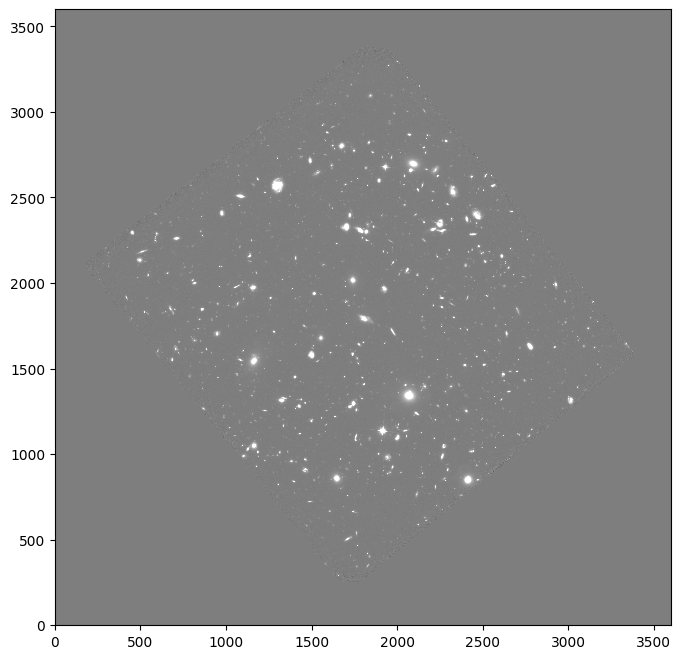

In [42]:
fig, ax = plt.subplots()
m, s = np.mean(udf_data), np.std(udf_data)
im = ax.imshow(udf_data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')
plt.savefig('figure5.png')

In [43]:
udf_data = udf_data.byteswap().newbyteorder()

udf_bkg = sep.Background(udf_data)

In [44]:
print(udf_bkg.globalback)
print(udf_bkg.globalrms)

0.0
0.0005398219218477607


In [45]:
udf_bkg_image = udf_bkg.back()

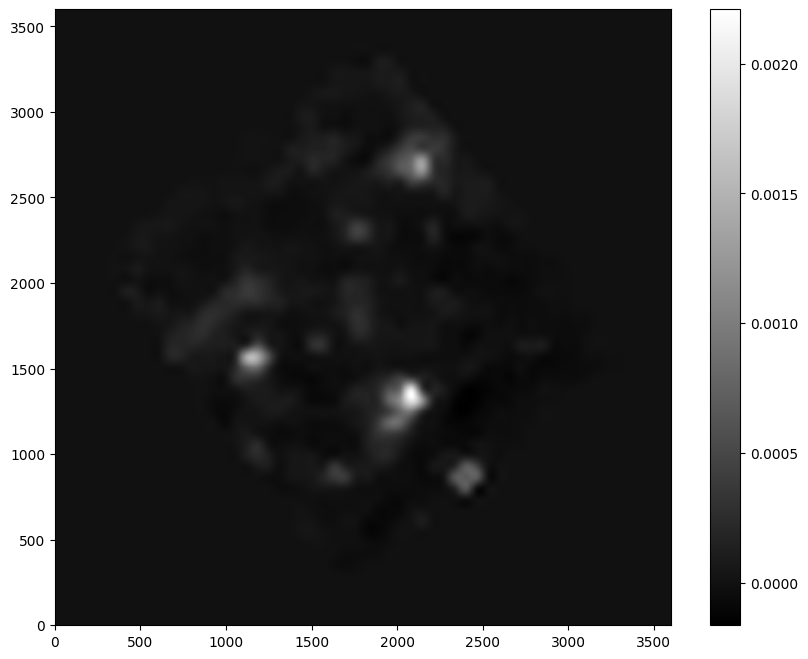

In [46]:
plt.imshow(udf_bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('figure6.png')

In [47]:
udf_bkg_rms = udf_bkg.rms()

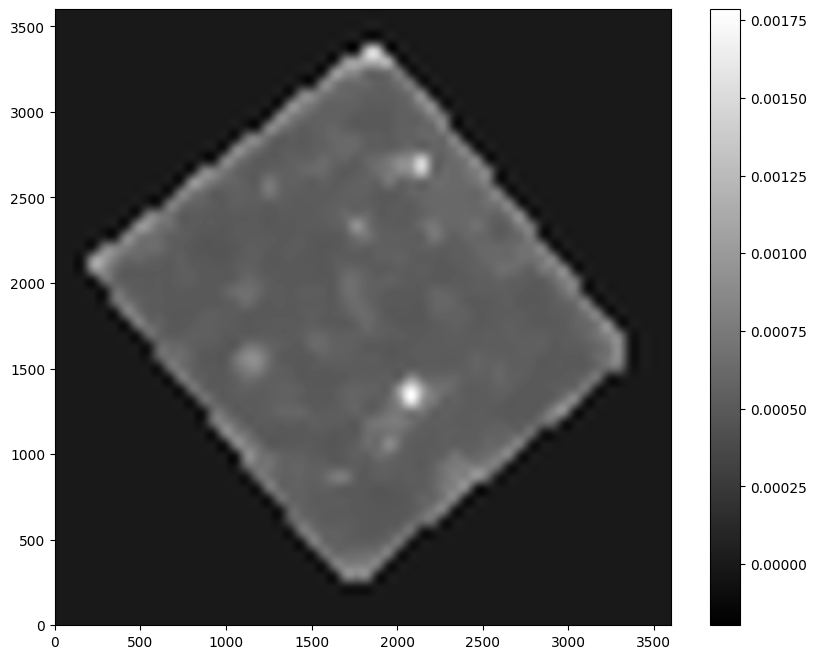

In [48]:
plt.imshow(udf_bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('figure7.png')

In [49]:
udf_data_sub = udf_data - udf_bkg

In [50]:
udf_objects = sep.extract(udf_data_sub, 1.5, err=udf_bkg.globalrms)

In [51]:
print("Number of sources found in the UDF image:",len(udf_objects))

Number of sources found in the UDF image: 8640


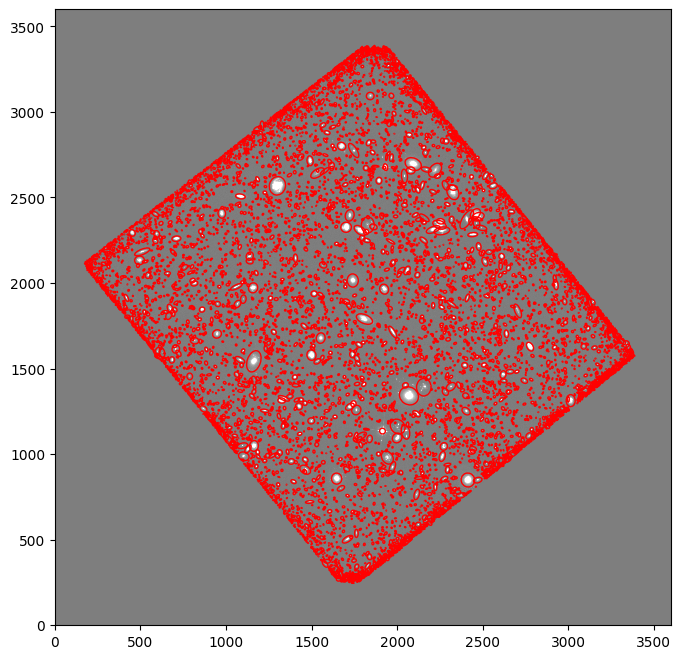

In [52]:
fig, ax = plt.subplots()
m, s = np.mean(udf_data_sub), np.std(udf_data_sub)
im = ax.imshow(udf_data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(udf_objects)):
    e = Ellipse(xy=(udf_objects['x'][i], udf_objects['y'][i]),
                width=6*udf_objects['a'][i],
                height=6*udf_objects['b'][i],
                angle=udf_objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('figure8.png')

In [53]:
udf_objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [54]:
flux, fluxerr, flag = sep.sum_circle(udf_data_sub, udf_objects['x'], udf_objects['y'],
                                     3.0, err=udf_bkg.globalrms, gain=1.0)

In [55]:
for i in range(10):
    print("Objects {:d}: Flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

Objects 0: Flux = 0.031282 +/- 0.176890
Objects 1: Flux = 0.031018 +/- 0.176142
Objects 2: Flux = -0.024388 +/- 0.002883
Objects 3: Flux = 0.001947 +/- 0.044219
Objects 4: Flux = 0.012457 +/- 0.111649
Objects 5: Flux = -0.011228 +/- 0.002875
Objects 6: Flux = 0.029368 +/- 0.171394
Objects 7: Flux = -0.009126 +/- 0.002875
Objects 8: Flux = 0.048023 +/- 0.219161
Objects 9: Flux = 0.027840 +/- 0.166877


In [56]:
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

print("Mean Flux:", mean_flux)
print("Median Flux:", median_flux)
print("Standard Deviation Flux:", std_flux)

Mean Flux: 0.36186200071901703
Median Flux: 0.030956558069156016
Standard Deviation Flux: 9.243527842776762


In [57]:
largest_outlier_index = np.argmax(flux)
largest_outlier_flux = flux[largest_outlier_index]
largest_outlier_position = (udf_objects['x'][largest_outlier_index], udf_objects['y'][largest_outlier_index])
largest_outlier_std_devs = (largest_outlier_flux - mean_flux) / std_flux

print("\nLargestOutlier:")
print("Flux:", largest_outlier_flux)
print("Position (x, y):", largest_outlier_position)
print("Standard Deviations from Mean:", largest_outlier_std_devs)


LargestOutlier:
Flux: 807.2972835731507
Position (x, y): (1914.2549094883857, 1134.3164850742164)
Standard Deviations from Mean: 87.29734310293674


In [58]:
f125w_data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
f160w_data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")

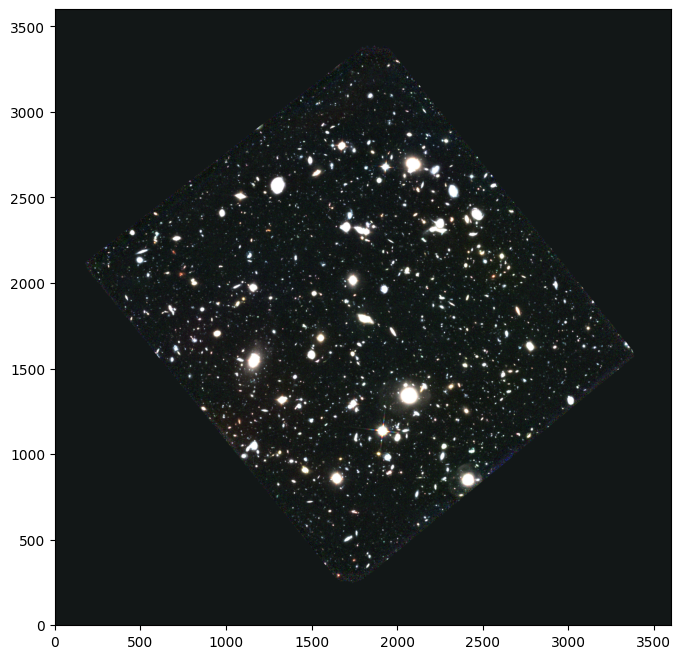

In [59]:
def linear_scale(data, scale_percentile=(1, 99)):
    vmin, vmax = np.percentile(data, scale_percentile)
    scaled_data = np.clip((data - vmin) / (vmax - vmin), 0, 1)
    return scaled_data

# Apply linear scaling to each channel
scaled_f160w = linear_scale(f160w_data)
scaled_f125w = linear_scale(f125w_data)
scaled_udf = linear_scale(udf_data)

# Create the 3-color RGB image
rgb_image = np.stack([scaled_f160w, scaled_f125w, scaled_udf], axis=-1)

# Display the 3-color false image
plt.imshow(rgb_image, origin='lower')

plt.imsave('udf_3color_false.png', rgb_image)